In [52]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../solver'))
from solver_rostering import Instance, Solver
from argparse import Namespace
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [21]:
# Define model
base_file = 'berlin_db=0.50'
model = "fixed"
outsourcing_cost_multiplier = 1.2
regional_multiplier = 1.5
global_multiplier = 0.8
h_min = 32
h_max = 48
max_n_diff = 3
max_n_shifts = 3

weekday_ = f'{base_file}_dt=doublepeak.json'
weekend_ = f'{base_file}_dt=uniform.json'

instance_file_weekday = f"../../instances/{weekday_}"
instance_file_weekend = f"../../instances/{weekend_}"

shift_file_weekday = f"../../shifts/{weekday_}"
shift_file_weekend = f"../../shifts/{weekend_}"

args = Namespace(
    model=model,
    instance_file_weekday=instance_file_weekday,
    shift_file_weekday = shift_file_weekday,
    instance_file_weekend=instance_file_weekend,
    shift_file_weekend = shift_file_weekend,
    workforce_dict = {0:1, 1:1, 2:1, 3:1, 4:1, 5:1},

    outsourcing_cost_multiplier=outsourcing_cost_multiplier,
    regional_multiplier=regional_multiplier,
    global_multiplier=global_multiplier,

    h_min = h_min,
    h_max = h_max,
    max_n_diff = max_n_diff,
    max_n_shifts=max_n_shifts,
    expand_workforce_to_regions = False
)

In [22]:
def workforce_size(args):
    objective_value = float('inf')
    objective_value_list = []
    workforce_size_list = []
    change = 0
    size = 1

    # Build initial workforce size dictionary
    i = Instance(args=args)
    workforce_dict = {}
    for region in i.population.keys():
        workforce_dict[region] = 1

    args.workforce_dict = workforce_dict
    
    # Optimize workforce sizing for first region
    #while change <= 0:
    for _ in range(1, 45):
        print(size)
        args.workforce_dict[0] = size
        i = Instance(args=args)
        solver = Solver(args=args, i=i)
        results = solver.solve_roster_objval()
        
        # Check if the objective value is nan
        if math.isnan(results['objective_value'][0]):
            break
        else:
            change = results['objective_value'][0] - objective_value
            objective_value = results['objective_value'][0]
            objective_value_list.append(objective_value)
            workforce_size_list.append(size)
            size += 1

    # Scale the workforce size for the other regions
    workforce_size_region_0 = workforce_size_list[-2]
    population = i.population
    for region in workforce_dict.keys():
        workforce_dict[region] = math.floor(population[region] * workforce_size_region_0 / population[0])

    return workforce_size_list , objective_value_list

In [23]:
size_list, obj_list = workforce_size(args=args)

1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [31]:
sns.set_palette(palette=['#AC2C0C', '#3A7E5E', '#495867','#577399','#BDD5EA','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

/var/folders/js/pnl2ymz143j6txn5bftwltm40000gn/T/ipykernel_83099/1164703834.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


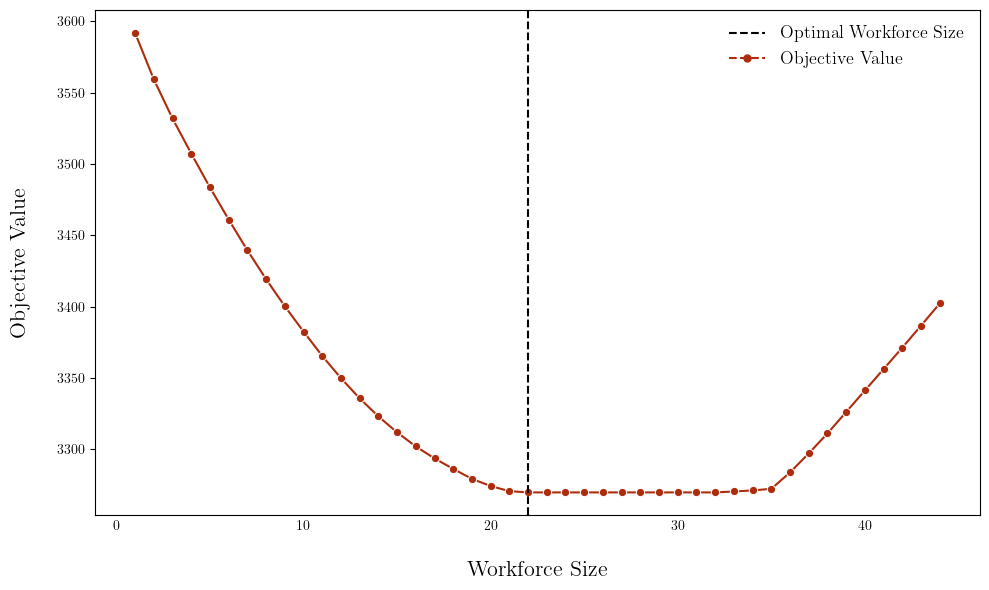

In [58]:
plt.rcParams['hatch.linewidth'] = 2  # Set the line width for hatches

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a line plot with 'o' markers
sns.lineplot(
    x=size_list, y=obj_list,
    marker='o', dashes=False, ax=ax, palette=sns.color_palette(), 
)
ax.legend().set_visible(True)
ax.axes.set_axisbelow(True)
ax.axes.set_xticks([0, 10, 20, 30, 40])
ax.set_xlabel('Workforce Size', fontsize=16, labelpad=20)
ax.set_ylabel('Objective Value', fontsize=16, labelpad=20)
ax.axvline(x=22, color='black', linestyle='--', label='Optimal Workforce Size')

# Remove x-axis tick marks
ax.tick_params(which='major', axis='x', length=0)

ax.legend(handles=[
    Line2D([0], [0], color='black', linestyle='--', label='Optimal Workforce Size'),
    Line2D([0], [0], marker='o', linestyle='--', color='#AC2C0C', markerfacecolor='#AC2C0C', markersize=5, label='Objective Value')
], loc='upper right', ncols=1, frameon=False, fontsize=13)


# Adjust layout to make room for elements and save the figure
fig.tight_layout()
fig.savefig('figures/workforce_size.pdf', dpi=96, bbox_inches='tight')
plt.show()
